In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
sns.set_palette('icefire')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

### Read data

In [2]:
df = pd.read_csv('../data/train.csv', na_values="NAN")
df.shape

(1460, 81)

Clean-up / handling missing values

In [3]:
## Following are the list of features, where the missing value have a meaning of either not-applicable or not-avaliable. Here I am replace with 'None' for encoding later.
null_has_meaning = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                    'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                    'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for f in null_has_meaning:
    df[f].fillna('None', inplace = True)

In [4]:
#missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685
KitchenQual,0,0.000000


In [5]:
## Observe features with missing values
cols_with_na = [f for f in df.columns if sum(~df[f].isna()) != len(df)]
df[cols_with_na].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   MasVnrType   1452 non-null   object 
 2   MasVnrArea   1452 non-null   float64
 3   Electrical   1459 non-null   object 
 4   GarageYrBlt  1379 non-null   float64
dtypes: float64(3), object(2)
memory usage: 57.2+ KB


1. Drop LotFrontage because of nearly 18% missing values
2. Reset impute the missing values as below:
    - Missing values in the string features are replaced with mode
    - Missing values in the numerical features are replaced with median

In [6]:
df.drop(columns = ['LotFrontage'], inplace = True)

In [7]:
for f in [c for c in cols_with_na if c in df.columns]:
    if df[f].dtypes == object:
        df[f].fillna(df[f].dropna().mode().values[0], inplace = True)
    else:
        df[f].fillna(df[f].dropna().median(), inplace = True)

In [8]:
cols_with_na = [f for f in df.columns if sum(~df[f].isna()) != len(df)]
cols_with_na

[]

We have no more missing values...

### Organize Features

In [9]:
# drop Id column because it is not useful
df.drop(columns = ['Id'], inplace = True)

In [10]:
# target
target = 'SalePrice'            # target is a numerical feature

# numerical features
num_features = [f for f in df.columns if (df[f].dtype in ['int64', float]) & (f != target)]

# catagorical features
cat_features = [f for f in df.columns if (df[f].dtype == object) & (f != target)]

print(f'Total columns in the dataset: {df.shape[1]}')
print(f'Total # of numerical features: {len(num_features)}')
print(f'Total # of numerical features: {len(cat_features)}')

Total columns in the dataset: 79
Total # of numerical features: 35
Total # of numerical features: 43


In [11]:
print('NUMERICAL FEATURES')
print(', '.join(num_features))
print()
print('CATEGORICAL FEATURES')
print(', '.join(cat_features))

NUMERICAL FEATURES
MSSubClass, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, TotRmsAbvGrd, Fireplaces, GarageYrBlt, GarageCars, GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, MiscVal, MoSold, YrSold

CATEGORICAL FEATURES
MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, Heating, HeatingQC, CentralAir, Electrical, KitchenQual, Functional, FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC, Fence, MiscFeature, SaleType, SaleCondition


### Data Preparation
- Encode categorical features
- Transform and scale numerical features

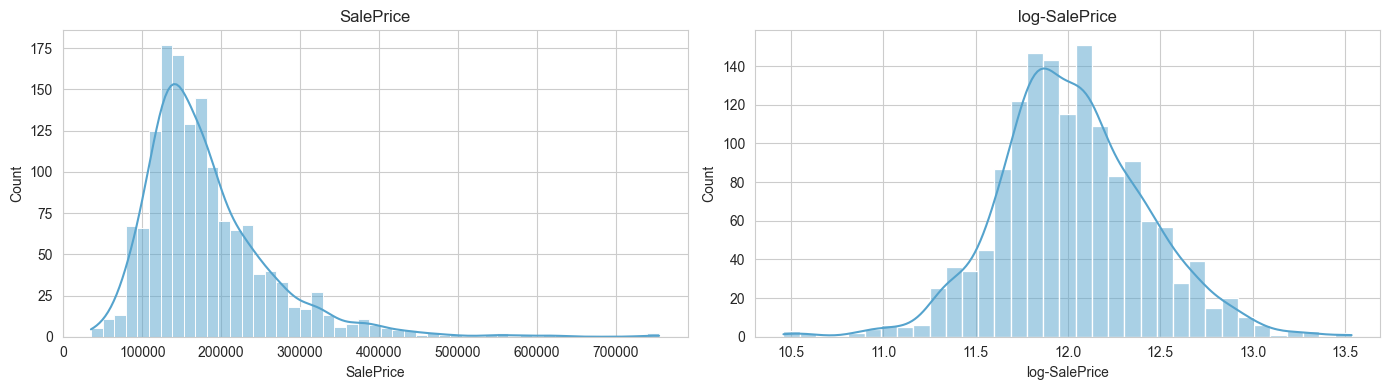

In [12]:
### Target
fig, axes = plt.subplots(1, 2, figsize = (14, 4))
sns.histplot(data = df, x = target, kde = True, ax = axes[0])
axes[0].set(title = target)

# log-transformation
df[f'log-{target}'] = df[target].apply(np.log)
sns.histplot(data = df, x = f'log-{target}', kde = True, ax = axes[1])
axes[1].set(title = f'log-{target}')

plt.tight_layout()
plt.show()


Original sale price is a right-skewed distribution, where only few houses with > 500,000. With log-transformation, the distribution is near-normal.

In [13]:
### Categorical features
# - simple numerical encoding is performed and the order of the labels is not considered particularly
for f in cat_features:           # loop over categorical features
    feature_set = sorted(list(set(df[f])))     # identify unique values in the feature
    for idx, j in enumerate(feature_set, start = 0):
        df.loc[df[f] == j, f] = idx     # replace string with the index of unique list

In [14]:
df.head()

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,log-SalePrice
0,60,3,8450,1,1,3,3,0,4,0,...,3,4,1,0,2,2008,8,4,208500,12.247694
1,20,3,9600,1,1,3,3,0,2,0,...,3,4,1,0,5,2007,8,4,181500,12.109011
2,60,3,11250,1,1,0,3,0,4,0,...,3,4,1,0,9,2008,8,4,223500,12.317167
3,70,3,9550,1,1,0,3,0,0,0,...,3,4,1,0,2,2006,8,0,140000,11.849398
4,60,3,14260,1,1,0,3,0,2,0,...,3,4,1,0,12,2008,8,4,250000,12.429216


### Model building

In [15]:
log_target = f'log-{target}'
X = df.drop(columns = [target, log_target])
y = df[log_target]

X_features = X.columns
X_features

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'Ope

In [16]:
# since we considered all the categorial features are ordinal, we can scale both the numerical and categorical features together
features_scaler = StandardScaler()
X = features_scaler.fit_transform(X)

# Scaler target
target_scaler = StandardScaler()
y = target_scaler.fit_transform(y.values.reshape(-1, 1))

Split dataset into train and test

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 3407)
len(y_train), len(y_test)

(1021, 439)

Baseline model with linear regression (no feature selection was performed)

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(f'Train R-square: {r2_score(lr.predict(X_train), y_train)}')
print(f'Test R-square: {r2_score(lr.predict(X_test), y_test)}')

Train R-square: 0.8770704883840961
Test R-square: -0.0022831050226712613


With no regularization, the model performance was decent but can be improved.

LASSO Regression
- parameter: Alpha
    - is 0              : Unregularized model
    - is greater than 0 : More regularization and leads to underfitting
    - is lesser than 0  : Less regularization and leads to overfitting


In [19]:
results = []
alphas = np.linspace(1e-3, 0.1, num = 200)
for a in alphas:
    lr = Lasso(alpha=a)     # no regulaization
    lr.fit(X_train,y_train)
    train_r2 = r2_score(lr.predict(X_train), y_train)
    test_r2 = r2_score(lr.predict(X_test), y_test)
    results.append((a, train_r2, test_r2))

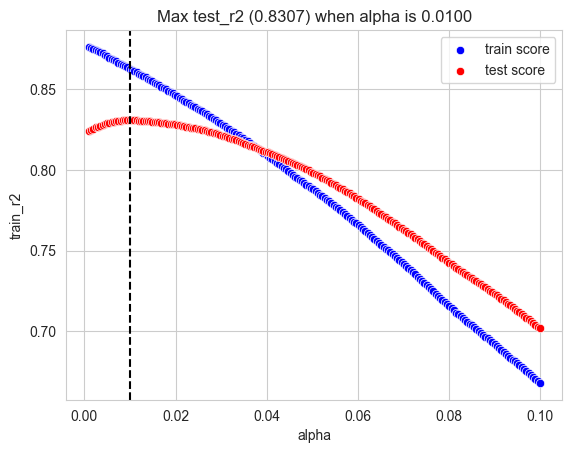

In [20]:
results_df = pd.DataFrame(results, columns = ['alpha', 'train_r2', 'test_r2'])
sns.scatterplot(data = results_df, x = 'alpha', y = 'train_r2', marker = 'o', color = 'blue')
sns.scatterplot(data = results_df, x = 'alpha', y = 'test_r2', marker = 'o', color = 'red')
max_test_r2 = max(results_df['test_r2'])
alpha_at_max = results_df.loc[results_df['test_r2'] == max_test_r2, 'alpha'].values[0]
plt.axvline(x = alpha_at_max, color = 'black', ls = '--')
plt.title(f'Max test_r2 ({max_test_r2:.4f}) when alpha is {alpha_at_max:.4f}')
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

Better can be done with gridsearch CV

In [21]:
model = Lasso()
folds = 5       # 5-fold cross-validation
params = {'alpha': np.linspace(1e-3, 0.05, num = 200)}
model_cv = GridSearchCV(estimator=model,
                        param_grid = params,
                        scoring = 'r2',
                        cv = folds,
                        return_train_score = True,
                        verbose = 1)
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([0.001     , 0.00124623, 0.00149246, 0.00173869, 0.00198492,
       0.00223116, 0.00247739, 0.00272362, 0.00296985, 0.00321608,
       0.00346231, 0.00370854, 0.00395477, 0.00420101, 0.00444724,
       0.00469347, 0.0049397 , 0.00518593, 0.00543216, 0.00567839,
       0.00592462, 0.00617085, 0.00641709, 0.00666332, 0.00690955,
       0.00715578, 0.00740...
       0.0428593 , 0.04310553, 0.04335176, 0.04359799, 0.04384422,
       0.04409045, 0.04433668, 0.04458291, 0.04482915, 0.04507538,
       0.04532161, 0.04556784, 0.04581407, 0.0460603 , 0.04630653,
       0.04655276, 0.04679899, 0.04704523, 0.04729146, 0.04753769,
       0.04778392, 0.04803015, 0.04827638, 0.04852261, 0.04876884,
       0.04901508, 0.04926131, 0.04950754, 0.04975377, 0.05      ])},
             return_train_score=True, scoring='r2', verbose=1)

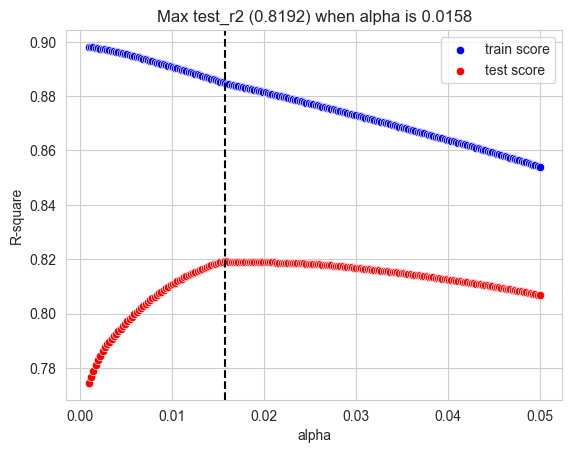

In [22]:
results_df = pd.DataFrame(model_cv.cv_results_)

# plotting mean test and train scoes with alpha
results_df['param_alpha'] = results_df['param_alpha'].astype('float32')

# plot
sns.scatterplot(data = results_df, x = 'param_alpha', y = 'mean_train_score',
                marker = 'o', color = 'blue')
sns.scatterplot(data = results_df, x = 'param_alpha', y = 'mean_test_score', 
                marker = 'o', color = 'red')
max_test_r2 = max(results_df['mean_test_score'])
alpha_at_max = results_df.loc[results_df['mean_test_score'] == max_test_r2, 'param_alpha'].values[0]
plt.axvline(x = alpha_at_max, color = 'black', ls = '--')
plt.xlabel('alpha')
plt.ylabel('R-square')
plt.title(f'Max test_r2 ({max_test_r2:.4f}) when alpha is {alpha_at_max:.4f}')
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

Train model on best alpha (0.0197) for feature selection

In [23]:
model = Lasso(alpha = alpha_at_max)
model.fit(X_train, y_train)
print(f'Train R-square: {r2_score(model.predict(X_train), y_train):.6f}')
print(f'Test R-square: {r2_score(model.predict(X_test), y_test):.6f}')

# Features importance by coefficient in absolute terms
lasso_fdf = pd.DataFrame({'feature': X_features, 'coef': model.coef_, 'abs_coef': abs(model.coef_)})
lasso_fdf.sort_values(by = 'abs_coef', ascending = False, inplace = True)

non_zero_coef = lasso_fdf[lasso_fdf['coef'] != 0]
print(f'Features selected after removing those with 0 coefficient: {len(non_zero_coef)}', '\n')

print('Top 6 features on coefficient:')
lasso_fdf.head(6)[['feature', 'coef']]

Train R-square: 0.853466
Test R-square: 0.829580
Features selected after removing those with 0 coefficient: 46 

Top 6 features on coefficient:


,feature,coef
15,OverallQual,0.283027
44,GrLivArea,0.211370
59,GarageCars,0.136912
16,OverallCond,0.090527
17,YearBuilt,0.077608
45,BsmtFullBath,0.073688


In [24]:
### Double alpha
model = Lasso(alpha = alpha_at_max * 2)
model.fit(X_train, y_train)
print(f'Train R-square: {r2_score(model.predict(X_train), y_train):.6f}')
print(f'Test R-square: {r2_score(model.predict(X_test), y_test):.6f}')

# Features importance by coefficient in absolute terms
lasso_fdf = pd.DataFrame({'feature': X_features, 'coef': model.coef_, 'abs_coef': abs(model.coef_)})
lasso_fdf.sort_values(by = 'abs_coef', ascending = False, inplace = True)

non_zero_coef = lasso_fdf[lasso_fdf['coef'] != 0]
print(f'Features selected after removing those with 0 coefficient: {len(non_zero_coef)}', '\n')

print('Top 6 features on coefficient:')
lasso_fdf.head(6)[['feature', 'coef']]

Train R-square: 0.825779
Test R-square: 0.820082
Features selected after removing those with 0 coefficient: 33 

Top 6 features on coefficient:


,feature,coef
15,OverallQual,0.298975
44,GrLivArea,0.221464
59,GarageCars,0.147070
17,YearBuilt,0.076923
16,OverallCond,0.070617
39,CentralAir,0.070615


In [28]:
# After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?

top_5_indices = [15, 44, 59, 17, 16]
selected_indices = [i for i in range(X_train.shape[1]) if i not in top_5_indices]
X_train_sub = X_train[:, selected_indices]
X_test_sub = X_test[:, selected_indices]

In [30]:
### Grid search for alpha
model = Lasso()
folds = 5       # 5-fold cross-validation
params = {'alpha': np.linspace(1e-3, 0.05, num = 200)}
model_cv = GridSearchCV(estimator=model,
                        param_grid = params,
                        scoring = 'r2',
                        cv = folds,
                        return_train_score = True,
                        verbose = 1)
model_cv.fit(X_train_sub, y_train)

## Rrsults
results_df = pd.DataFrame(model_cv.cv_results_)
results_df['param_alpha'] = results_df['param_alpha'].astype('float32')
max_test_r2 = max(results_df['mean_test_score'])
alpha_at_max = results_df.loc[results_df['mean_test_score'] == max_test_r2, 'param_alpha'].values[0]
print(f'Alpha at max r2: {alpha_at_max:.6f}')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Alpha at max r2: 0.021437


In [33]:
model = Lasso(alpha = alpha_at_max)
model.fit(X_train_sub, y_train)
print(f'Train R-square: {r2_score(model.predict(X_train_sub), y_train):.6f}')
print(f'Test R-square: {r2_score(model.predict(X_test_sub), y_test):.6f}')

# Features importance by coefficient in absolute terms
X_features_sub = [f for idx, f in enumerate(X_features) if idx not in top_5_indices]
lasso_fdf = pd.DataFrame({'feature': X_features_sub, 'coef': model.coef_, 'abs_coef': abs(model.coef_)})
lasso_fdf.sort_values(by = 'abs_coef', ascending = False, inplace = True)

non_zero_coef = lasso_fdf[lasso_fdf['coef'] != 0]
print(f'Features selected after removing those with 0 coefficient: {len(non_zero_coef)}', '\n')

print('Top 6 features on coefficient:')
lasso_fdf.head(6)[['feature', 'coef']]

Train R-square: 0.794487
Test R-square: 0.769454
Features selected after removing those with 0 coefficient: 39 

Top 6 features on coefficient:


,feature,coef
38,1stFlrSF,0.161356
39,2ndFlrSF,0.147127
55,GarageArea,0.123250
43,FullBath,0.105039
15,YearRemodAdd,0.103954
50,Fireplaces,0.102047


Ridge Regression
- parameter: Alpha


In [ ]:
model = Ridge()
folds = 5       # 5-fold cross-validation
params = {'alpha': [0.1**i for i in range(5, 0, -1)] \
                    + [i for i in range(10)] \
                    + [i*1 for i in range(1, 100)]
                    + [i*10 for i in range(1, 100)]
        }
model_cv = GridSearchCV(estimator=model,
                        param_grid = params,
                        scoring = 'r2',
                        cv = folds,
                        return_train_score = True,
                        verbose = 1)
model_cv.fit(X, y)

In [ ]:
results_df = pd.DataFrame(model_cv.cv_results_)

# plotting mean test and train scoes with alpha
results_df['param_alpha'] = results_df['param_alpha'].astype('int32')

# plot
sns.scatterplot(data = results_df, x = 'param_alpha', y = 'mean_train_score',
                marker = 'o', color = 'blue')
sns.scatterplot(data = results_df, x = 'param_alpha', y = 'mean_test_score', 
                marker = 'o', color = 'red')
max_test_r2 = max(np.abs(results_df['mean_test_score']))
alpha_at_max = results_df.loc[np.abs(results_df['mean_test_score']) == max_test_r2, 'param_alpha'].values[0]
plt.axvline(x = alpha_at_max, color = 'black', ls = '--')
plt.xlabel('alpha')
plt.ylabel('r-square')
plt.title(f'Max test_r2 ({max_test_r2:.4f}) when alpha is {alpha_at_max:.4f}')
plt.legend(['train score', 'test score'], loc='upper right')
plt.show()

Train model with best alpha (240) for feature selection

In [ ]:
model = Ridge(alpha = alpha_at_max)
model.fit(X_train, y_train)
print(f'Train R-square: {r2_score(model.predict(X_train), y_train):.6f}')
print(f'Test R-square: {r2_score(model.predict(X_test), y_test):.6f}')

# Features importance by coefficient in absolute terms
coefs = model.coef_.flatten()
ridge_fdf = pd.DataFrame({'feature': X_features, 'coef': coefs, 'abs_coef': abs(coefs)})
ridge_fdf.sort_values(by = 'abs_coef', ascending = False, inplace = True)

non_zero_coef = ridge_fdf[lasso_fdf['abs_coef'] < 1e-4]
print(f'Features selected after removing those with coefficient <1e-4 on absolute terms: {len(non_zero_coef)}', '\n')

print('Top 6 features on coefficient:')
ridge_fdf.head(6)[['feature', 'coef']]

In [ ]:
model = Ridge(alpha = alpha_at_max * 2)
model.fit(X_train, y_train)
print(f'Train R-square: {r2_score(model.predict(X_train), y_train):.6f}')
print(f'Test R-square: {r2_score(model.predict(X_test), y_test):.6f}')

# Features importance by coefficient in absolute terms
coefs = model.coef_.flatten()
ridge_fdf = pd.DataFrame({'feature': X_features, 'coef': coefs, 'abs_coef': abs(coefs)})
ridge_fdf.sort_values(by = 'abs_coef', ascending = False, inplace = True)

non_zero_coef = ridge_fdf[lasso_fdf['abs_coef'] < 1e-4]
print(f'Features selected after removing those with coefficient <1e-4 on absolute terms: {len(non_zero_coef)}', '\n')

print('Top 6 features on coefficient:')
ridge_fdf.head(6)[['feature', 'coef']]